Es wird entschieden keine der Spalten zu löschen, da diese für eine spätere Analyse möglicherweise wichtig sind.
Vielmehr sollen für die Durchführung des LDAs lediglich englische Lieder im Datensatz behalten werden.

In [14]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

import nltk
from nltk.corpus import stopwords

from pprint import pprint

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
#Samaras Laptop
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\DIE_DATEN\datensatz.csv')
#song_data = song_data[(song_data['Language'] == 'en')]
#song_data.to_csv("outData.csv", index=False)
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\outData.csv')


#Anjas Laptop
# song_data = pd.read_csv('../Daten/train.csv')
# song_data = song_data[(song_data['Language'] == 'en')]
# song_data.to_csv("../Daten/outData.csv", index=False)
song_data = pd.read_csv('../Daten/outData.csv')

## Data Cleaning

In [4]:
# Remove the columns
song_data_subset = song_data_subset[['Genre', 'Lyrics']]
# Print out the first rows of papers
song_data_subset.head(5)

,Genre,Lyrics
0,Rock,"It starts with pain, followed by hate\nFueled ..."
1,Rock,Freedom!\nAlone again again alone\nPatiently w...
2,Rock,"Biting the hand that feeds you, lying to the v..."
3,Rock,You say you know just who I am\nBut you can't ...
4,Rock,My heart is beating faster can't control these...


## Remove punctuation/lower casing

In [5]:
# Remove punctuation
song_data_subset['song_text_processed'] = \
song_data_subset['Lyrics'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
song_data_subset['song_text_processed'] = \
song_data_subset['song_text_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
song_data_subset['song_text_processed'].head()

0    it starts with pain followed by hate\nfueled b...
1    freedom\nalone again again alone\npatiently wa...
2    biting the hand that feeds you lying to the vo...
3    you say you know just who i am\nbut you can't ...
4    my heart is beating faster can't control these...
Name: song_text_processed, dtype: object

## Analyse für ein Lied

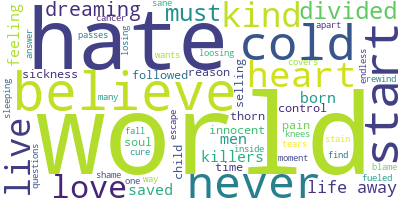

In [6]:
# Join the different processed titles together.
lyrics_for_one_song = song_data_subset.loc[0, 'song_text_processed']
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(lyrics_for_one_song)
# Visualize the word cloud
wordcloud.to_image()

In [7]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield gensim.utils.simple_preprocess(str(sentence), deacc=True)

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Assuming you have a DataFrame named 'songs_data' with a column 'lyrics'
song_data_subset['lyrics_processed'] = remove_stopwords(sent_to_words(song_data_subset['Lyrics']))

# Create a dictionary and a corpus for each song
corpora = []
dictionaries = []
lda_models = []
topics_words = []

num_topics = 5  # Change this to the desired number of topics

for i, song_lyrics in enumerate(song_data_subset['lyrics_processed']):
    # Create Dictionary
    id2word = gensim.corpora.Dictionary([song_lyrics])

    # Create Corpus
    corpus = [id2word.doc2bow(song_lyrics)]

    corpora.append(corpus)
    dictionaries.append(id2word)

    # Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)
    lda_models.append(lda_model)

    # Get the most dominant topic for each song
    song_topics = lda_model.get_document_topics(corpus[0], minimum_probability=0.0)
    dominant_topic = max(song_topics, key=lambda x: x[1])[0]
    
    # Extract the words of the dominant topic
    topic_words = lda_model.print_topic(dominant_topic).split('"')[1::2]
    topics_words.append(topic_words)

    # Print the Keywords in the topics for the current song
    print(f"Keywords for Song {i + 1} - Topic {dominant_topic}: {', '.join(topic_words)}")

# Add the 'topics_words' column to the DataFrame
song_data_subset['topics_words'] = topics_words
song_data_subset

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anjan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Keywords for Song 1 - Topic 2: world, hate, believe, never, cold, live, dreaming, life, heart, must
Keywords for Song 2 - Topic 3: broken, know, away, cause, need, inside, pain, deep, heart, take
Keywords for Song 3 - Topic 2: given, take, lesson, life, self, listen, killing, find, breakdown, reach
Keywords for Song 4 - Topic 4: feeling, thousand, feels, hearts, remember, back, pain, hell, see, still
Keywords for Song 5 - Topic 0: heart, beating, control, faster, anymore, enough, see, feelings, go, get
Keywords for Song 6 - Topic 0: feeling, feels, thousand, hearts, remember, back, still, see, hell, pain
Keywords for Song 7 - Topic 4: back, give, away, nothing, mine, place, inside, perfect, time, going
Keywords for Song 8 - Topic 3: need, show, mother, father, okay, find, pill, let, trying, deeper
Keywords for Song 9 - Topic 4: know, showed, stand, real, see, time, taught, become, leavin, behind
Keywords for Song 10 - Topic 2: stand, get, back, know, stay, away, see, things, mind, noth

,Genre,Lyrics,song_text_processed,lyrics_processed,topics_words
0,Rock,"It starts with pain, followed by hate\nFueled ...",it starts with pain followed by hate\nfueled b...,"[starts, pain, followed, hate, fueled, endless...","[world, hate, believe, never, cold, live, drea..."
1,Rock,Freedom!\nAlone again again alone\nPatiently w...,freedom\nalone again again alone\npatiently wa...,"[freedom, alone, alone, patiently, waiting, ph...","[broken, know, away, cause, need, inside, pain..."
2,Rock,"Biting the hand that feeds you, lying to the v...",biting the hand that feeds you lying to the vo...,"[biting, hand, feeds, lying, voice, inside, re...","[given, take, lesson, life, self, listen, kill..."
3,Rock,You say you know just who I am\nBut you can't ...,you say you know just who i am\nbut you can't ...,"[say, know, imagine, waits, across, line, thou...","[feeling, thousand, feels, hearts, remember, b..."
4,Rock,My heart is beating faster can't control these...,my heart is beating faster can't control these...,"[heart, beating, faster, control, feelings, an...","[heart, beating, control, faster, anymore, eno..."
5,Rock,You say you know just who I am\nBut you can't ...,you say you know just who i am\nbut you can't ...,"[say, know, imagine, waits, across, line, thou...","[feeling, feels, thousand, hearts, remember, b..."
6,Rock,Looking for light in the darkness\nIs somethin...,looking for light in the darkness\nis somethin...,"[looking, light, darkness, something, fools, s...","[back, give, away, nothing, mine, place, insid..."
7,Rock,"Mother mother can you hear me,I keep trying\nJ...",mother mother can you hear mei keep trying\nju...,"[mother, mother, hear, keep, trying, find, kno...","[need, show, mother, father, okay, find, pill,..."
8,Rock,"It was you,\nThat showed me who I am,\nAnd tau...",it was you\nthat showed me who i am\nand taugh...,"[showed, taught, stand, know, real, sick, pain...","[know, showed, stand, real, see, time, taught,..."
9,Rock,\nI hear the words you say to me\nI see the wa...,\ni hear the words you say to me\ni see the wa...,"[hear, words, say, see, way, look, know, mind,...","[stand, get, back, know, stay, away, see, thin..."


In [11]:
for i, topic in enumerate(topics):
    print(f"Song {i + 1} has dominant topic: {topic}")
    print(f"Keywords for Song {i + 1} - Topic {topic}:")
    pprint(lda_models[i].print_topics())
    print("\n")

Song 1 has dominant topic: (0, 0.0027920525)
Keywords for Song 1 - Topic (0, 0.0027920525):
[(0,
  '0.059*"world" + 0.037*"believe" + 0.034*"hate" + 0.032*"never" + '
  '0.027*"divided" + 0.027*"cold" + 0.027*"must" + 0.026*"live" + 0.025*"away" '
  '+ 0.025*"heart"'),
 (1,
  '0.071*"world" + 0.034*"believe" + 0.033*"hate" + 0.029*"cold" + '
  '0.026*"dreaming" + 0.026*"away" + 0.025*"life" + 0.024*"kind" + '
  '0.024*"heart" + 0.023*"love"'),
 (2,
  '0.062*"world" + 0.041*"hate" + 0.036*"believe" + 0.031*"never" + '
  '0.031*"cold" + 0.027*"live" + 0.026*"dreaming" + 0.025*"life" + '
  '0.024*"heart" + 0.024*"must"'),
 (3,
  '0.024*"world" + 0.022*"believe" + 0.020*"hate" + 0.019*"never" + '
  '0.019*"cold" + 0.019*"love" + 0.019*"life" + 0.018*"must" + 0.018*"live" + '
  '0.018*"dreaming"'),
 (4,
  '0.069*"world" + 0.033*"never" + 0.031*"cold" + 0.029*"believe" + '
  '0.028*"love" + 0.027*"hate" + 0.025*"must" + 0.025*"kind" + 0.025*"divided" '
  '+ 0.024*"heart"')]


Song 2 has domi

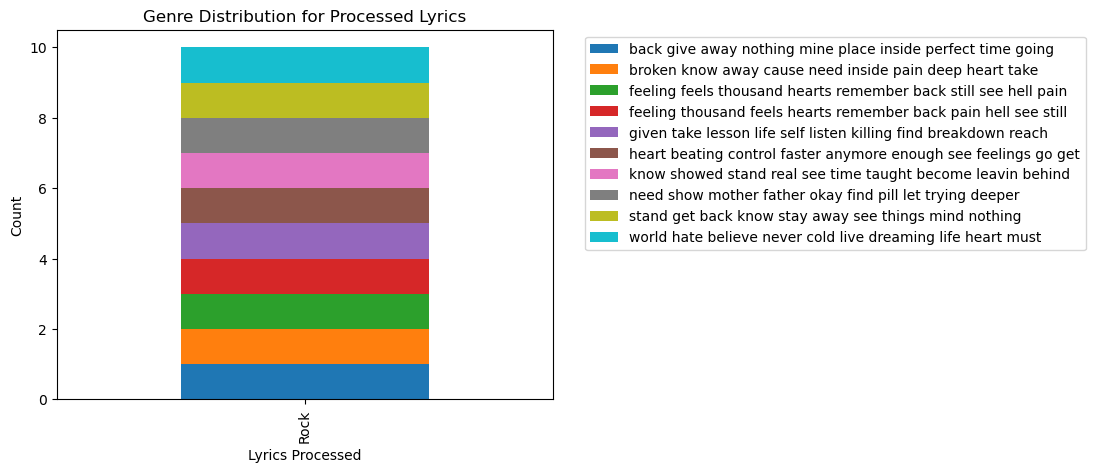

In [9]:
# Assuming 'lyrics_processed' column contains lists of words
song_data_subset['lyrics_processed_str'] = song_data_subset['topics_words'].apply(lambda x: ' '.join(x))

# Create a crosstab
crosstab = pd.crosstab(song_data_subset['Genre'], song_data_subset['lyrics_processed_str'])

# Plot the crosstab
crosstab.plot(kind='bar', stacked=True).legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Lyrics Processed')
plt.ylabel('Count')
plt.title('Genre Distribution for Processed Lyrics')
plt.show()

In [16]:
# Assuming 'lyrics_processed' column contains lists of words
song_data_subset['lyrics_processed_str'] = song_data_subset['topics_words'].apply(lambda x: ' '.join(x))

# Vectorize the lyrics using TF-IDF
X = vectorizer.transform(song_data_subset['lyrics_processed_str'])

# Apply PCA to reduce dimensionality to 2 features
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Add PCA features to DataFrame
song_data_subset['PCA_Feature_1'] = X_pca[:, 0]
song_data_subset['PCA_Feature_2'] = X_pca[:, 1]

# Visualize the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA_Feature_1', y='PCA_Feature_2', hue='cluster', palette='viridis', data=song_data_subset)
plt.title('Clustering of Processed Lyrics')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.show()

song_data_subset


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\anjan\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\anjan\AppData\Local\Temp\ipykernel_13520\3764096888.py", line 5, in <module>
    X = vectorizer.transform(song_data_subset['lyrics_processed_str'])
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\anjan\anaconda3\envs\Studienarbeit\Lib\site-packages\sklearn\feature_extraction\text.py", line 2155, in transform
    check_is_fitted(self, msg="The TF-IDF vectorizer is not fitted")
  File "c:\Users\anjan\anaconda3\envs\Studienarbeit\Lib\site-packages\sklearn\utils\validation.py", line 1390, in check_is_fitted
    raise NotFittedError(msg % {"name": type(estimator).__name__})
sklearn.exceptions.NotFittedError: The TF-IDF vectorizer is not fitted

During handling of the above exception, another exception occurred:

Traceback